# fPCA applied to spatiotemporal reconstruction of EEG data around braking event  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd 
import os

## <font color='blue'> Import learning data </font>

In [2]:
# Import spatial mesh 
# Extract data mnt - contains information on the EVENTS
path_data_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/Data/Raw/'
file_name = "VPja.mat" # VPja.mat ; VPbax.mat
with h5py.File(path_data_mat + file_name, 'r') as f:
    mnt = f.get('mnt')
    print("Items in mnt", list(mnt.items()) )
    x_pos_allChannels = np.array(mnt.get('x'))
    y_pos_allChannels = np.array(mnt.get('y'))
    pos3d_allChannels = np.array(mnt.get('pos_3d')) # coord in 3D

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]
print(pos3d_eegChannels.shape)
#spatiotemp_coord = np.repeat(pos3d_eegChannels[np.newaxis,:, :], 320, axis=0)

Items in mnt [('box', <HDF5 dataset "box": shape (70, 2), type "<f8">), ('box_sz', <HDF5 dataset "box_sz": shape (70, 2), type "<f8">), ('clab', <HDF5 dataset "clab": shape (69, 1), type "|O">), ('pos_3d', <HDF5 dataset "pos_3d": shape (69, 3), type "<f8">), ('scale_box', <HDF5 dataset "scale_box": shape (1, 2), type "<f8">), ('scale_box_sz', <HDF5 dataset "scale_box_sz": shape (1, 2), type "<f8">), ('x', <HDF5 dataset "x": shape (1, 69), type "<f8">), ('y', <HDF5 dataset "y": shape (1, 69), type "<f8">)]
(59, 3)


In [2]:
#path_data_explore = '/Users/obando_c/Documents/Neuro/EmergencyBraking/Data/post_processed/AllSubjects_events/'
#files = sorted([elt for elt in os.listdir(path_data_explore) if elt[-4:] == '.npy'],
#                   key=(lambda x: int(x.split('_')[2])))
#ex = np.load(path_data_explore + "VPae.mat_segment_1_event.npy")
#ex_pd = pd.DataFrame(data = ex)

In [6]:
# DO NOT RUN
path_data_explore = '/Users/obando_c/Documents/Neuro/EmergencyBraking/Data/post_processed/AllSubjects_events/'
files = sorted([elt for elt in os.listdir(path_data_explore) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))
df_eeg_events = pd.DataFrame([])
for file in files:
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_data_explore,file)))
    df_eeg_events = df_eeg_events.append(df_interval)
df_eeg_events.to_csv(r'df_eeg_only_events_all_subjects.csv', index = False)

In [7]:
len(files)

3908

In [11]:
df_eeg_events_file = 'df_eeg_only_events_all_subjects.csv' # Corresponds to VPja
#Lecture
df_eeg_events = pd.read_csv( df_eeg_events_file )

In [12]:
#Traitement  
NPeeg = np.asarray(df_eeg_events)
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
mu_t    = NPeegC.mean(axis=0) # Pour avoir des processus centrés

In [13]:
df_eeg_events.shape

(230572, 320)

In [14]:
NPeeg.shape

(230572, 320)

##  <font color='blue'>FPCA </font>

In [5]:
# Building the spatio temporal mesh 
nSample = len(files) # 
spatiotemp_mesh = []
for p in pos3d_eegChannels:
    xi, yi, zi = tuple(p)
    for ti in range(320):
        spatiotemp_mesh.append([xi, yi, zi, ti])

NameError: name 'files' is not defined

In [18]:
# Transforming my EEG into the format of the mesh - each entry must correspond 
nn_channels = 59
values = []
for k in range(len(files)):
    start = k * 59
    end = start + 59
    #values.append( NPeegC[start:end].ravel() ) # 
    values.append( (NPeegC[start:end,:].T - mu_t.reshape(-1,1)).T.ravel() ) # Pour avoir des processus centrés

In [51]:
# OpenTurns:
import openturns as ot
num_f = len(files)
dim_ch_in = 1 # # corresponds to process_sample
dim_ch_out = 1 # # corresponds to  field
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), num_f, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    field.setValues(np.array(values[k]).reshape(-1,1))
    process_sample[k] = field

### <font color='green'> Etape 1: KarhunenLoeve </font>

In [25]:
s = 0.0 # 
w_v = np.ones(59*320) 
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) #0.0 (=s) correspond au threshold sur les valeurs propres
algo.run()

fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

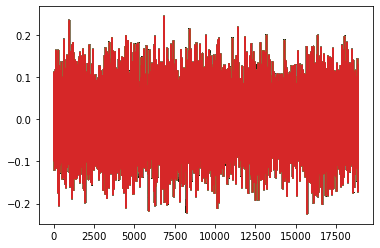

In [36]:
T     = np.array([t for t in spatiotemp_mesh]) # .reshape(-1,1)
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()-1):
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [43]:
T     = np.array([t for t in spatiotemp_mesh]) # .reshape(-1,1)
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

mean_res = []
for k in range(process_sample.getSize()):
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    mean_res.append(abs(np.asarray(res)).mean())

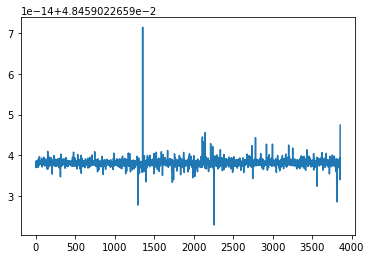

In [44]:
plt.plot(mean_res)

### <font color='green'> Etape 2: PCA - erreur de troncature</font>

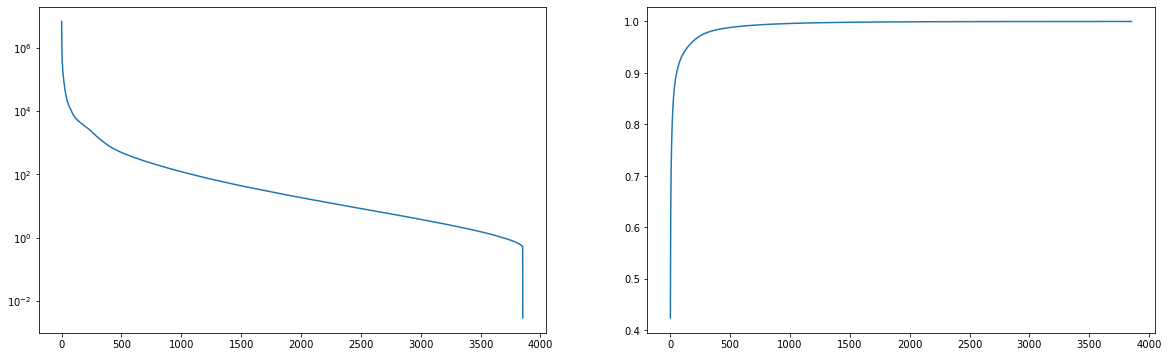

In [46]:
vp      = fPCA.getEigenValues() #  getEigenValues method enables to obtain the K first eigenvalues of the Karhunen Loeve decomposition
pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].semilogy(vp)
ax[1].plot (pVar)

## <font color='blue'> La détection d'anomalies </font>

In [47]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)

[93, 142, 207, 222, 260, 333, 349, 370, 518, 586, 782, 944, 988, 1098, 1125, 1206, 1235, 1290, 1292, 1348, 1353, 1511, 1529, 1532, 1604, 1644, 1650, 1665, 1767, 1788, 1941, 2039, 2109, 2130, 2143, 2145, 2189, 2739, 2747, 2921, 2955, 2997, 3233, 3253, 3299, 3668, 3718]


### <font color='green'> Minimum Level Set </font>

On prend 2 modes (c'est plus facile pour visualiser), et on cherche la ligne de niveau qui minimise la surface sur le plan $\xi [0]$ x $\xi [1]$.

Ensuite on peut tester sur pour un signal donné, sa projection sur les 2 axes principaux est à l'intérieur ou à l'extérieur de cette surface.

 Nb Outlier =  0


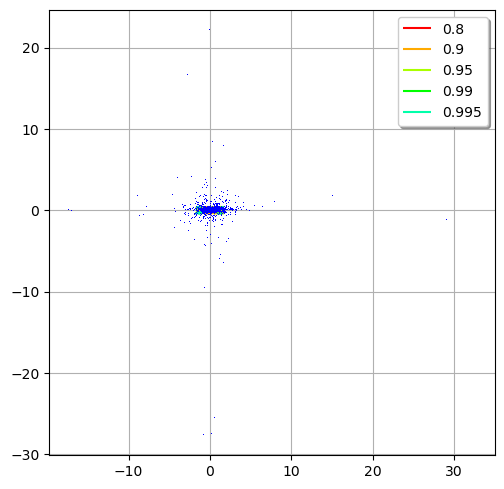

In [48]:
import openturns.viewer as otv 

#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))